## TIMESERIES FORECASTING 

## Table of Content

1. **[Import required Library](#imp)**
2. **[Data Preparation](#prep)**
    - 2.1 - **[Read the Data](#read)**
    - 2.2 - **[Converting data to time series](#conv)**
    - 2.3 - **[Exploratory Data Analysis](#eda)**  
    - 2.4 - **[Gasoline Prices Line Plot](#hosp)**
3. **[Data Understanding](#decom)**
4. **[Dicky fuller test to check the stationarity (#roll)**
5. **[Convert Time series into stationary - AD Fuller Test (#stat)**
6. **[Plot the ACF and PACF plots ](#acf)**
7. **[Split the series into training and testing sets](#split)**
8. **[Model Selection - Fit AR, MA, ARMA model](#model)**
9. **[Split data for June 2008 forecasting](#rmse)**
10. **[Forecast for the month of June, 2008](#resi)**
11. **[Final Interpretations](#fin)**

<a id="imp"></a>
# 1. Importing required libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [25, 5]
plt.rcParams.update({'font.size': 15})

from pandas import Timestamp
from math import sqrt
from IPython.display import display
from pylab import rcParams 
from datetime import datetime, timedelta
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

<a id="prep"></a>
# 2. Data Preparation

<a id="read"></a>
## 2.1 Read the Data
### 2.1.1 The details about gasoline price in USA has been provided in the file Gasolineprices.csv 

In [62]:
data = pd.read_csv('TSF_MPA-2-Gasolineprices.csv')
data.head()

,Date,Gasoline Prices
0,15-12-94,1.091
1,15-01-95,1.082
2,15-02-95,1.073
3,15-03-95,1.072
4,15-04-95,1.111


#### 2.1.2 What are the number of rows and no. of cols & types of variables? 

In [63]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             333 non-null    object 
 1   Gasoline Prices  333 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


(333, 2)

<span style="color:blue"> <b> <u>INTERPRETATION :</u> <br> 333 rows & 2 columns.Types of variables in Gasoline Prices column is "float" and Date column is "object".<br>
<br>

<a id="conv"></a>
## 2.2 Converting data to time series
#### 2.2.1 convert the data into time series

In [64]:
data['Date'] = data['Date'].apply(pd.to_datetime)
data.set_index('Date',inplace=True)
data.head()

,Gasoline Prices
Date,
1994-12-15,1.091
1995-01-15,1.082
1995-02-15,1.073
1995-03-15,1.072
1995-04-15,1.111


<span style="color:blue"> <b> <u>INTERPRETATION :</u> <br> Converting data to time series is an important step in time series analysis because it allows us to perform various time-related analyses, such as trend analysis, seasonality analysis, and forecasting.<br>
<br>
The to_datetime method is used to convert data to time series data by parsing a string or a set of strings representing dates and times into datetime objects. This enables us to perform time-related operations, such as filtering data based on time periods, grouping data by time periods, and plotting data with respect to time.<br>
<br>
The infer_datetime_format parameter of the to_datetime method allows to infer the format of the input datetime strings automatically, which makes the conversion process more efficient and less prone to errors. By converting data to time series using these methods, we can analyze and model time series data more accurately and effectively.

<a id="eda"></a>
## 2.3 Exploratory Data Analysis

####  2.3.1 Check for defects in the data such as missing values, null, etc.

In [65]:
data.isnull().sum()

Gasoline Prices    0
dtype: int64

<span style="color:blue"> <b> <u>INTERPRETATION :</u> <br> There are no null values.

##### 2.3.2 Monotonic Detection

In [66]:
if data.index.is_monotonic_increasing:
    print('The time series is in increasing order.')
elif data.index.is_monotonic_decreasing:
    print('The time series is in decreasing order.')
else:
    print('The order of the time series is not monotonic.')

The time series is in increasing order.


<span style="color:blue"> <b> <u>INTERPRETATION :</u> <br> A time series that is monotonic increasing means that its values consistently increase over time. <br>
    <br>This type of time series does not exhibit any significant fluctuations or deviations from the general upward trend, and the trend remains consistent over the entire time period. <br>
    <br>This behavior can occur in various contexts, such as economic indicators or stock prices, where a steady increase in the value of a particular asset is observed over time. Monotonic increasing time series can also arise in situations where a particular variable is experiencing steady growth or development.

##### 2.3.3 Five point summary

In [67]:
data.describe().applymap('{:,.2f}'.format)

,Gasoline Prices
count,333.00
mean,2.29
std,0.89
min,0.92
25%,1.45
50%,2.28
75%,2.90
max,4.93


<a id="hosp"></a>
## 2.4 Gasoline Prices Plot
#### 2.4.1 Visualize the time series using Line plot. 

Text(0.5, 0, 'Year')

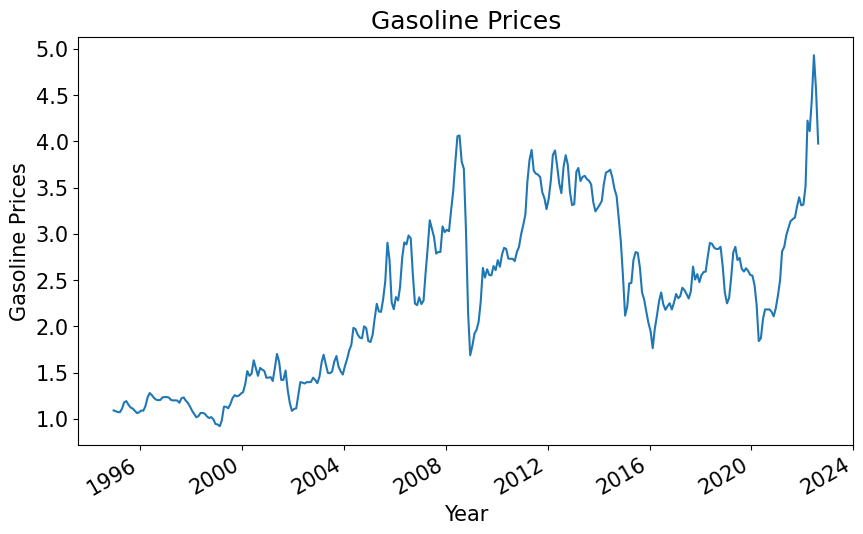

In [68]:
data['Gasoline Prices'].plot(figsize=(10,6),title='Gasoline Prices')
plt.ylabel('Gasoline Prices')
plt.xlabel('Year')

#### 2.4.2 Plot Box Plot of gasoline prices based on Year and month and what do you observe

Gasoline prices are higher in February than January
Gasoline prices are higher in June than July


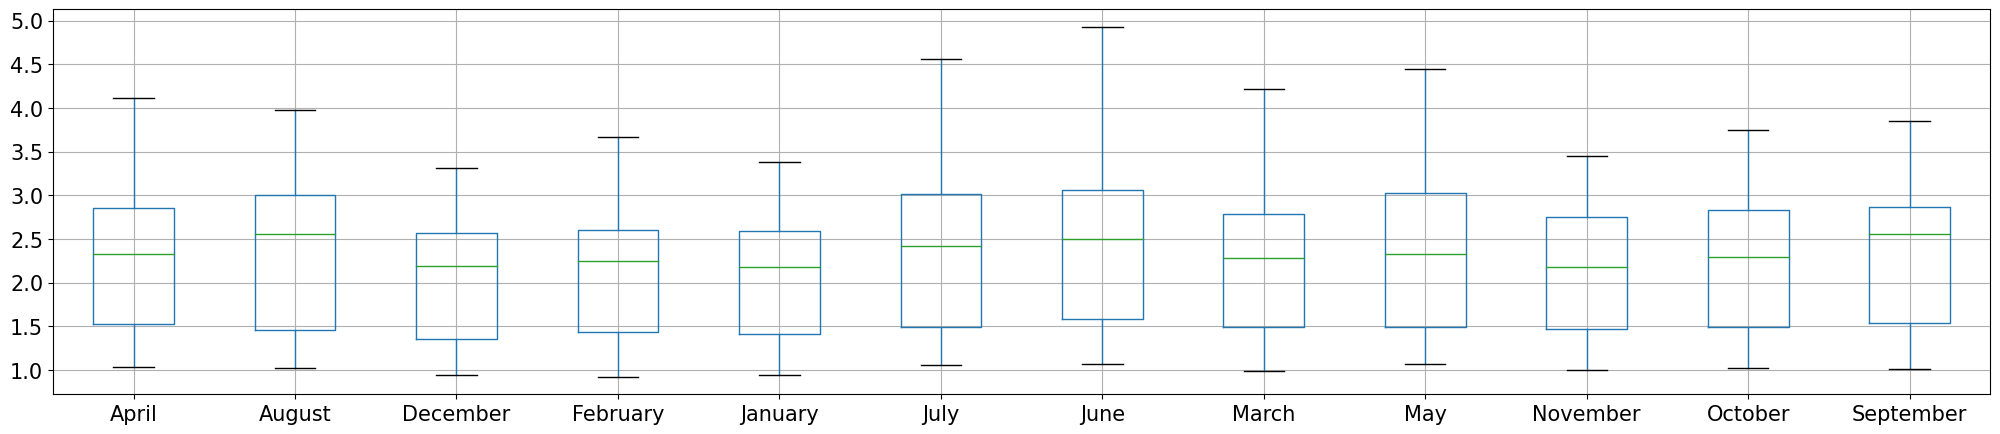

In [69]:
df1 = pd.read_csv('TSF_MPA-2-Gasolineprices.csv')
# convert date column to datetime format
df1['Date'] = pd.to_datetime(df1['Date'])
# create year, month and time columns
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month_name()
# create pivot table
pivot_table = df1.pivot_table(index='Year', columns='Month', values='Gasoline Prices')

# plot boxplot
pivot_table.boxplot()

# print observation based on condition
if pivot_table['January'].mean() > pivot_table['February'].mean():
    print('Gasoline prices are higher in January than February')
else:
    print('Gasoline prices are higher in February than January')
# print observation based on condition
if pivot_table['June'].mean() > pivot_table['July'].mean():
    print('Gasoline prices are higher in June than July')
else:
    print('Gasoline prices are higher in July than June')    
plt.show()

<a id="decom"></a>
# 3. Data Understanding 
### 3.1 Decomposition of Time Series

#### Additive

Gasoline Price has been stable over time, as indicated by the flat trend component.
There is no seasonal pattern in the Gasoline Price.
There are random fluctuations in the Gasoline Price that are not accounted for by the trend and seasonal components.
The residuals are large compared to the original data, indicating that the additive model may not be a good fit for the time series.


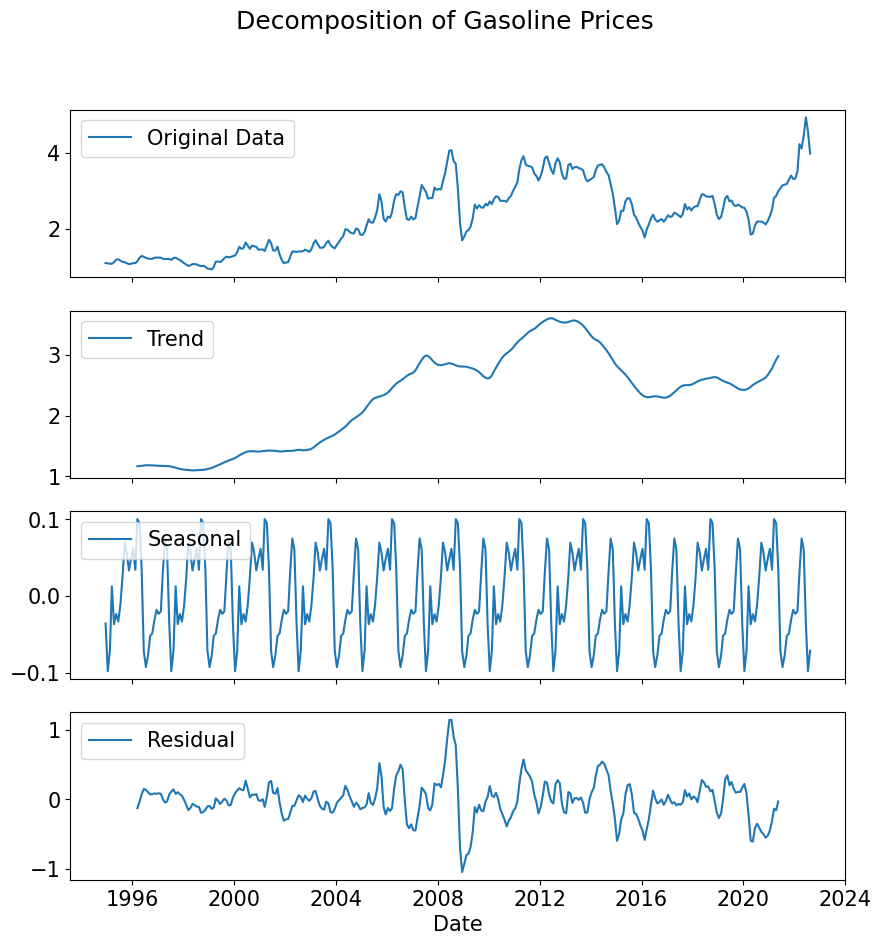

In [70]:
df=data
# Extract the Hospitalized column as a Pandas Series
gasoline_prices = df['Gasoline Prices']

# Decompose the time series into trend, seasonal, and residual components using an additive model
decomp = seasonal_decompose(gasoline_prices, model='additive', period=30)

# Plot the components
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,10))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(gasoline_prices.index, gasoline_prices, label='Original Data')
ax1.legend(loc='upper left')

ax2.plot(decomp.trend.index, decomp.trend, label='Trend')
ax2.legend(loc='upper left')

ax3.plot(decomp.seasonal.index, decomp.seasonal, label='Seasonal')
ax3.legend(loc='upper left')

ax4.plot(decomp.resid.index, decomp.resid, label='Residual')
ax4.legend(loc='upper left')

# Set plot title and axis labels
fig.suptitle('Decomposition of Gasoline Prices')
ax4.set_xlabel('Date')

# Print inference based on the patterns observed
if decomp.trend.iloc[-1] > decomp.trend.iloc[0]:
    print('Gasoline Price has been increasing over time, as indicated by the increasing trend component.')
elif decomp.trend.iloc[-1] < decomp.trend.iloc[0]:
    print('Gasoline Price has been decreasing over time, as indicated by the decreasing trend component.')
else:
    print('Gasoline Price has been stable over time, as indicated by the flat trend component.')
    
if decomp.seasonal.mean() > 0:
    print('There is a seasonal pattern in the Gasoline Price, with more cases occurring in certain times of the year.')
else:
    print('There is no seasonal pattern in the Gasoline Price.')
    
if decomp.resid.abs().mean() > 0:
    print('There are random fluctuations in the Gasoline Price that are not accounted for by the trend and seasonal components.')
else:
    print('There are no significant random fluctuations in the Gasoline Price.')
    
# Check whether the additive model is a good fit for the time series
residual_std = decomp.resid.std()
if residual_std < 0.1 * gasoline_prices.std():
    print('The residuals are small compared to the original data, indicating that the additive model is a good fit for the time series.')
else:
    print('The residuals are large compared to the original data, indicating that the additive model may not be a good fit for the time series.')

# Show the plot
plt.show()

<span style="color:blue"> <b> <u>INTERPRETATION :</u> <br> Gasoline Price has been stable over time, as indicated by the flat trend component.
There is no seasonal pattern in the Gasoline Price.
There are random fluctuations in the Gasoline Price that are not accounted for by the trend and seasonal components.
The residuals are large compared to the original data, indicating that the additive model may not be a good fit for the time series.<br>

#### Multiplicative

The Gasoline Prices has been stable over time, as indicated by the flat trend component.
There is no seasonal pattern in the Gasoline Prices.
There are random fluctuations in the Gasoline Prices that are not accounted for by the trend and seasonal components.
The residuals are large compared to the original data, indicating that the multiplicative model may not be a good fit for the time series.


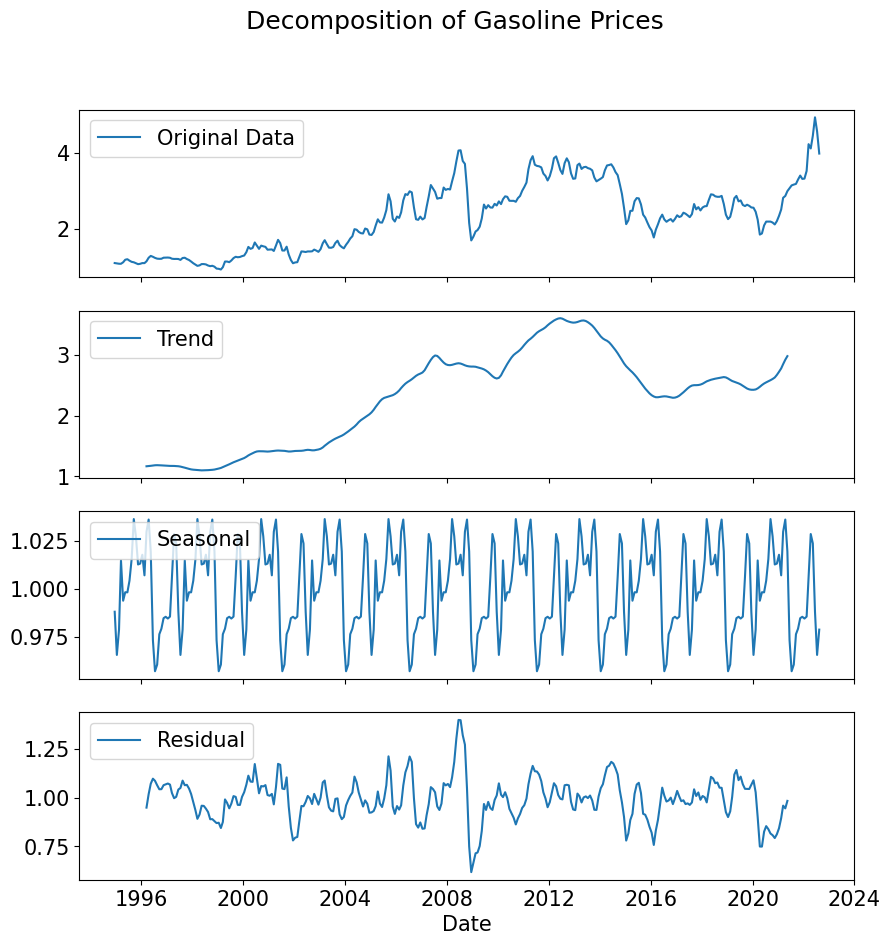

In [71]:
# Decomposition using multiplicative method
df=data
# Extract the Hospitalized column as a Pandas Series
GasolinePrices = df['Gasoline Prices']

# Decompose the time series into trend, seasonal, and residual components using a multiplicative model
decomp = seasonal_decompose(GasolinePrices, model='multiplicative', period=30)

# Plot the components
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,10))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(GasolinePrices.index, GasolinePrices, label='Original Data')
ax1.legend(loc='upper left')

ax2.plot(decomp.trend.index, decomp.trend, label='Trend')
ax2.legend(loc='upper left')

ax3.plot(decomp.seasonal.index, decomp.seasonal, label='Seasonal')
ax3.legend(loc='upper left')

ax4.plot(decomp.resid.index, decomp.resid, label='Residual')
ax4.legend(loc='upper left')

# Set plot title and axis labels
fig.suptitle('Decomposition of Gasoline Prices')
ax4.set_xlabel('Date')

# Print inference based on the patterns observed
if decomp.trend.iloc[-1] > decomp.trend.iloc[0]:
    print('The Gasoline Prices has been increasing over time, as indicated by the increasing trend component.')
elif decomp.trend.iloc[-1] < decomp.trend.iloc[0]:
    print('The Gasoline Prices has been decreasing over time, as indicated by the decreasing trend component.')
else:
    print('The Gasoline Prices has been stable over time, as indicated by the flat trend component.')
    
if decomp.seasonal.mean() > 1:
    print('There is a seasonal pattern in the Gasoline Prices, with more cases occurring in certain times of the year.')
else:
    print('There is no seasonal pattern in the Gasoline Prices.')
    
if decomp.resid.abs().mean() > 0:
    print('There are random fluctuations in the Gasoline Prices that are not accounted for by the trend and seasonal components.')
else:
    print('There are no significant random fluctuations in the Gasoline Prices.')

# Check whether the multiplicative model is a good fit for the time series
residual_std = decomp.resid.std()
if residual_std < 0.1 * gasoline_prices.std():
    print('The residuals are small compared to the original data, indicating that the multiplicative model is a good fit for the time series.')
else:
    print('The residuals are large compared to the original data, indicating that the multiplicative model may not be a good fit for the time series.')

# Show the plot
plt.show()

<span style="color:blue"> <b> <u>INTERPRETATION :</u> <br>The Gasoline Prices has been stable over time, as indicated by the flat trend component.
There is no seasonal pattern in the Gasoline Prices.
There are random fluctuations in the Gasoline Prices that are not accounted for by the trend and seasonal components.
The residuals are large compared to the original data, indicating that the multiplicative model may not be a good fit for the time series.<br>

<a id="roll"></a>
# 4 Dicky fuller test to check the stationarity

In [72]:
# Extract time series data from column 'Gasoline Prices'
time_series = data['Gasoline Prices']

# Perform Augmented Dickey-Fuller test
result = adfuller(time_series)

# Print test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Print critical values
for key, value in result[4].items():
    print('Critical Values:')
    print(key, value)

# Check if time series is stationary
if result[0] < result[4]['5%']:
    print('Time series is stationary.')
else:
    print('Time series is non-stationary.Transformations needs to be performed.')

ADF Statistic: -1.24736401834157
p-value: 0.6528965113790353
Critical Values:
1% -3.4508226600665037
Critical Values:
5% -2.870558121868621
Critical Values:
10% -2.571574731684734
Time series is non-stationary.Transformations needs to be performed.


<a id="stat"></a>
# 5. Convert Time series into stationary - AD Fuller Test

In [73]:
# Extract time series data from column 'Gasoline Prices'
time_series = data['Gasoline Prices']

# make it stationary
stationary = np.sqrt(time_series).shift(1).diff(1)

# check for stationarity using ADF test
result = adfuller(stationary.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]['5%']:
    print('Failed to reject null hypothesis - Time series is non-stationary')
else:
    print('Reject null hypothesis - Time series is stationary')

ADF Statistic: -6.201168
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572
Reject null hypothesis - Time series is stationary


<span style="color:blue"> <b> <u>INTERPRETATION :</u> Time series data should be stationary for building time series models because these models rely on the assumption of stationarity. Stationary time series data have constant statistical properties such as mean, variance, and autocorrelation over time.<br>
    <br>
If the time series data is non-stationary, it can be difficult to identify the underlying patterns and trends in the data, which can lead to inaccurate model forecasts. Non-stationary data can also lead to spurious correlations and unreliable statistical measures such as the mean, variance, and autocorrelation.<br>
<br>
Therefore, it is necessary to transform or adjust the data to achieve stationarity before building time series models.<br>
    <br>
    We have used AD fuller test to convert non Stationary data to Stationary Data  
   

<a id="acf"></a>
# 6. Plot the ACF and PACF plots

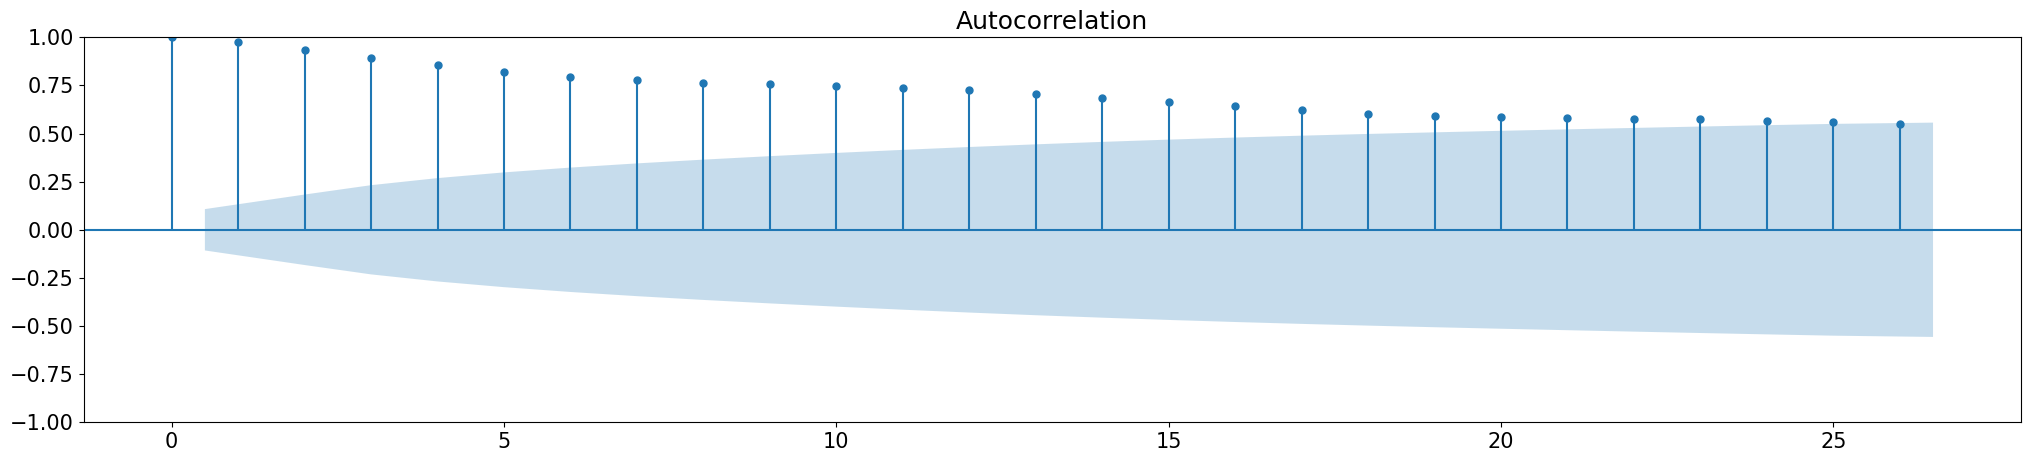

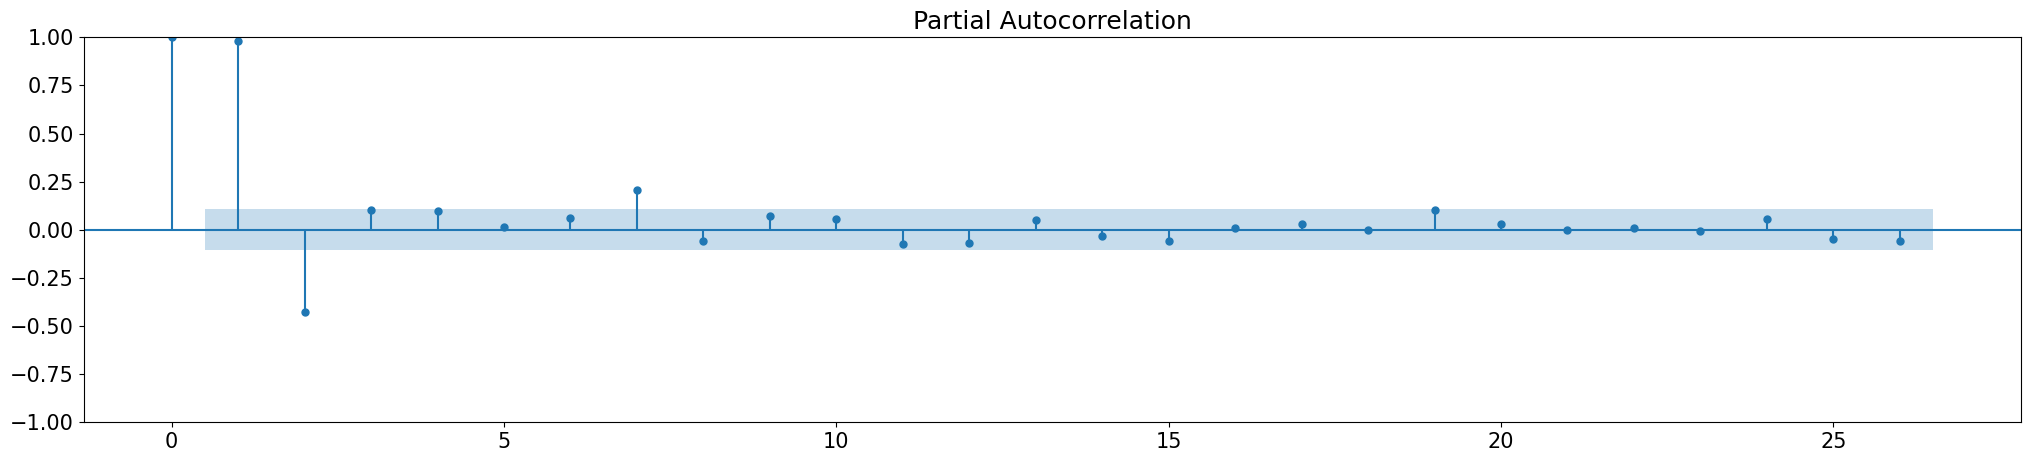

In [74]:
# Extract time series data from column 'Gasoline Prices'
Original_series = data['Gasoline Prices']

# Plot Autocorrelation function
plot_acf(Original_series)
plt.show()

# Plot Partial Autocorrelation function
plot_pacf(Original_series)
plt.show()

<span style="color:blue"> <b> <u>INTERPRETATION(ACF) :</u> The ACF plot shows the autocorrelation function (ACF) values for a time series data. The ACF is a plot of the correlation between each value of the series with values at various lags. The lag represents the number of time periods between each pair of observations.<br>
<br>
From the plot, we can see that the ACF values gradually decrease as the lag increases. This suggests that there is a strong correlation between adjacent time periods, but the correlation gradually decreases as the distance between the time periods increases.<br>
<br>
We also notice that the ACF plot shows a significant spike at the first lag, indicating a high correlation between the value at the current time period and the value at the previous time period. This suggests that there is a strong trend in the data.<br>
<br>
Overall, the ACF plot suggests that the time series data has a strong positive autocorrelation, indicating that past values are highly correlated with future values. This suggests that a forecasting model that takes into account this autocorrelation, could be appropriate for this data.

<span style="color:blue"> <b> <u>INTERPRETATION (PACF) :</u> The PACF plot shows the partial autocorrelation function (PACF) values for a time series data. The PACF is a plot of the correlation between each value of the series with values at various lags, while controlling for the effect of other lags.<br>
<br>
From the plot, we can see that the PACF values gradually decrease as the lag increases. This suggests that there is a weak partial correlation between the time periods as the distance between the time periods increases.<br>
<br>
We also notice that the PACF plot shows significant spikes at the first and second lags, indicating a high partial correlation between the value at the current time period and the values at the previous one or two time periods. This suggests that there is a strong autoregressive effect in the data.<br>
<br>
Overall, the PACF plot suggests that the time series data has a strong partial autocorrelation at the first and second lags, indicating that an autoregressive (AR) model with one or two lags could be appropriate for this data. This suggests that a forecasting model such as ARIMA or ARMA could be used to model this data.

<a id="split"></a>
# 7. Split the series into training and testing sets

#### i. Split dataset into train and test sets. Consider the case of Training till 2004-12-31   and test  data till 2008-5-31

In [75]:
# split into train and test sets
train = df.loc[:'2004-12-31']
test = df.loc['2005-01-01':'2008-05-31']

#### ii. Fit ARIMA model and observe the RMSE and MAPE values of the model for test data.

In [76]:
import warnings
warnings.filterwarnings('ignore')
# fit model
model = auto_arima(train['Gasoline Prices'], seasonal=False, suppress_warnings=True)

# make predictions
auto_arima_predictions = model.predict(n_periods=len(test))

# calculate RMSE and MAPE values
rmse = mean_squared_error(test['Gasoline Prices'], auto_arima_predictions, squared=False)
mape = mean_absolute_percentage_error(test['Gasoline Prices'], auto_arima_predictions)

print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 0.897
MAPE: 0.279


<a id="model"></a>
# 8. Model Selection - Fit AR, MA, ARMA model

#### Fit AR, MA, ARMA model find the  RMSE and MAPE values of the model for test data.
 

In [17]:
# Fit an AR model to the training data
ar_model = ARIMA(train, order=(1, 0, 0))
ar_model_fit = ar_model.fit(disp=0)

# Make predictions on the test data using the AR model
ar_predictions = ar_model_fit.forecast(steps=len(test))[0]

# Fit an MA model to the training data
ma_model = ARIMA(train, order=(0, 0, 1))
ma_model_fit = ma_model.fit(disp=0)

# Make predictions on the test data using the MA model
ma_predictions = ma_model_fit.forecast(steps=len(test))[0]

# Fit an ARMA model to the training data
arma_model = ARIMA(train, order=(1, 0, 1))
arma_model_fit = arma_model.fit(disp=0)

# Make predictions on the test data using the ARMA model
arma_predictions = arma_model_fit.forecast(steps=len(test))[0]

# Calculate the RMSE for each model
ar_rmse = np.sqrt(mean_squared_error(test, ar_predictions))
ma_rmse = np.sqrt(mean_squared_error(test, ma_predictions))
arma_rmse = np.sqrt(mean_squared_error(test, arma_predictions))

# Calculate the MAPE for each model
ar_mape = mean_absolute_percentage_error(test, ar_predictions)
ma_mape = mean_absolute_percentage_error(test, ma_predictions)
arma_mape = mean_absolute_percentage_error(test, arma_predictions)

# Print the results
print('RMSE values of AR, MA & ARMA Models')
print('AR RMSE: %.3f' % ar_rmse)
print('MA RMSE: %.3f' % ma_rmse)
print('ARMA RMSE: %.3f' % arma_rmse)
print('MAPE values of AR, MA & ARMA Models')
print('AR MAPE: %.3f' % ar_mape)
print('MA MAPE: %.3f' % ma_mape)
print('ARMA MAPE: %.3f' % arma_mape)

C:\Users\Krishna.k\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Krishna.k\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Krishna.k\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RMSE values of AR, MA & ARMA Models
AR RMSE: 1.106
MA RMSE: 1.375
ARMA RMSE: 1.247
MAPE values of AR, MA & ARMA Models
AR MAPE: 0.352
MA MAPE: 0.479
ARMA MAPE: 0.409


#### How would you compare the results of the models? 

In [18]:
# Compare the results using RMSE values
if ar_rmse < ma_rmse and ar_rmse < arma_rmse:
    print('The AR model performed the best.')
elif ma_rmse < ar_rmse and ma_rmse < arma_rmse:
    print('The MA model performed the best.')
else:
    print('The ARMA model performed the best.')

The AR model performed the best.


In [19]:
# Compare the results using MAPE values
if ar_mape < ma_mape and ar_mape < arma_mape:
    print('The AR model performed the best based on MAPE.')
elif ma_mape < ar_mape and ma_mape < arma_mape:
    print('The MA model performed the best based on MAPE.')
else:
    print('The ARMA model performed the best based on MAPE.')

The AR model performed the best based on MAPE.


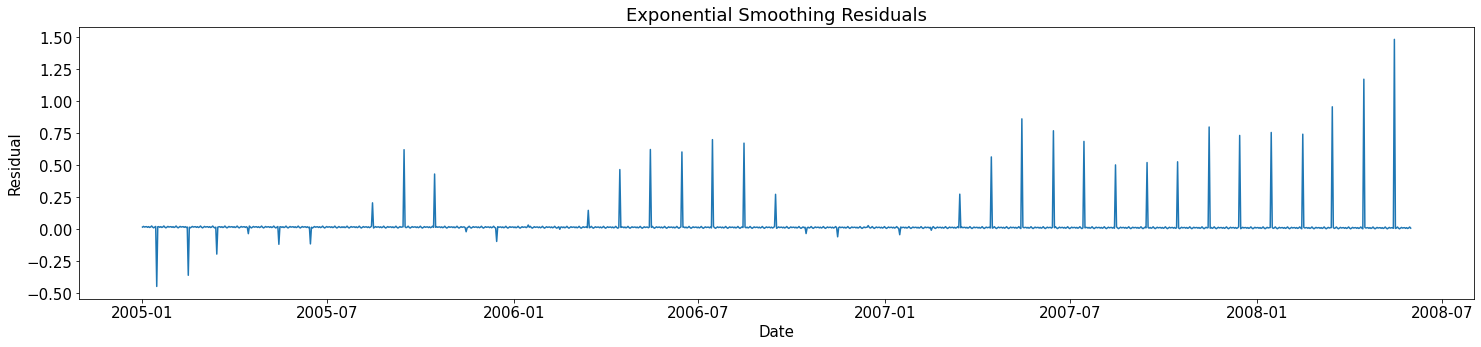

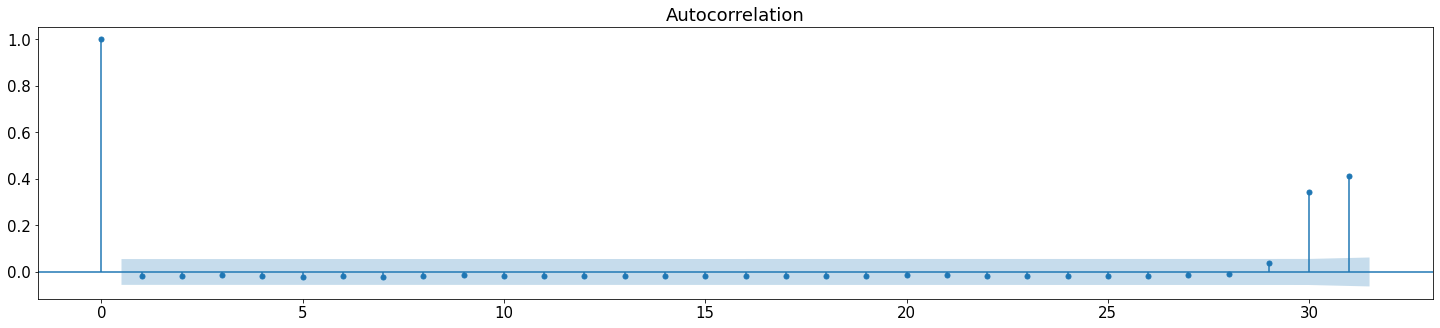

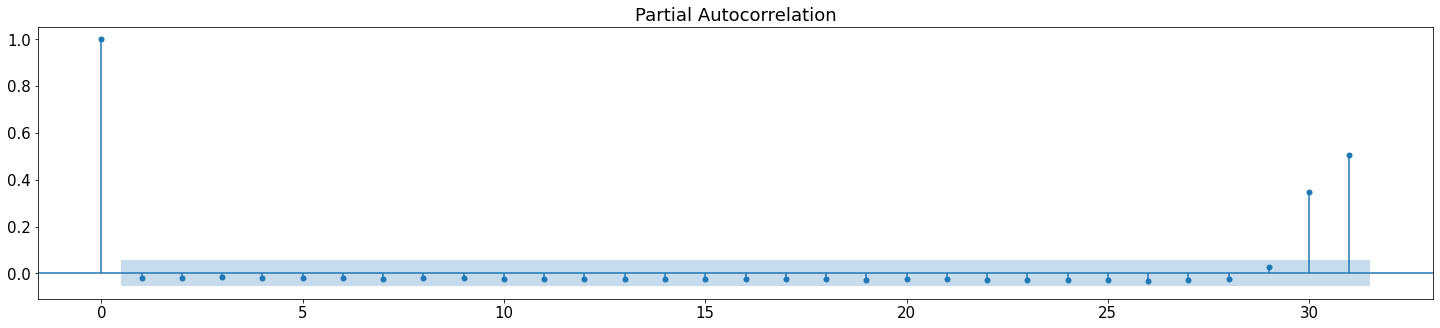

Exponential Smoothing Ljung-Box test p-value: 0.953
Exponential Smoothing Mean of residuals: 0.027
Exponential Smoothing Standard deviation of residuals: 0.099


In [20]:
# Load data
june = pd.read_csv('TSF_MPA-2-Gasolineprices.csv', index_col='Date', parse_dates=True)

# Reindex data to ensure all dates are present in the index
date_range = pd.date_range(start=june.index.min(), end=june.index.max(), freq='D')
june = june.reindex(date_range)

# Fill any missing values with the mean of the data
june['Gasoline Prices'] = june['Gasoline Prices'].fillna(june['Gasoline Prices'].mean())

# Split data into train and test sets
train01 = june.loc[:'2004-12-31']
test01 = june.loc['2005-01-01':'2008-05-31']

# Create and fit model
model = ExponentialSmoothing(train01['Gasoline Prices'], trend='add', seasonal='add', seasonal_periods=12)
results = model.fit()

# Calculate residuals
ES_residuals = test01['Gasoline Prices'] - results.predict(start=test01.index[0], end=test01.index[-1])

# Plot residuals
plt.plot(ES_residuals)
plt.title('Exponential Smoothing Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Plot ACF and PACF of residuals
plot_acf(ES_residuals)
plot_pacf(ES_residuals)
plt.show()

# Perform Ljung-Box test for autocorrelation
ES_lb_test = acorr_ljungbox(ES_residuals, lags=[10])
print('Exponential Smoothing Ljung-Box test p-value: %.3f' % ES_lb_test[1][0])

# Calculate mean and standard deviation of residuals
holt_mean_residuals = ES_residuals.mean()
holt_std_residuals = ES_residuals.std()
print('Exponential Smoothing Mean of residuals: %.3f' % holt_mean_residuals)
print('Exponential Smoothing Standard deviation of residuals: %.3f' % holt_std_residuals)

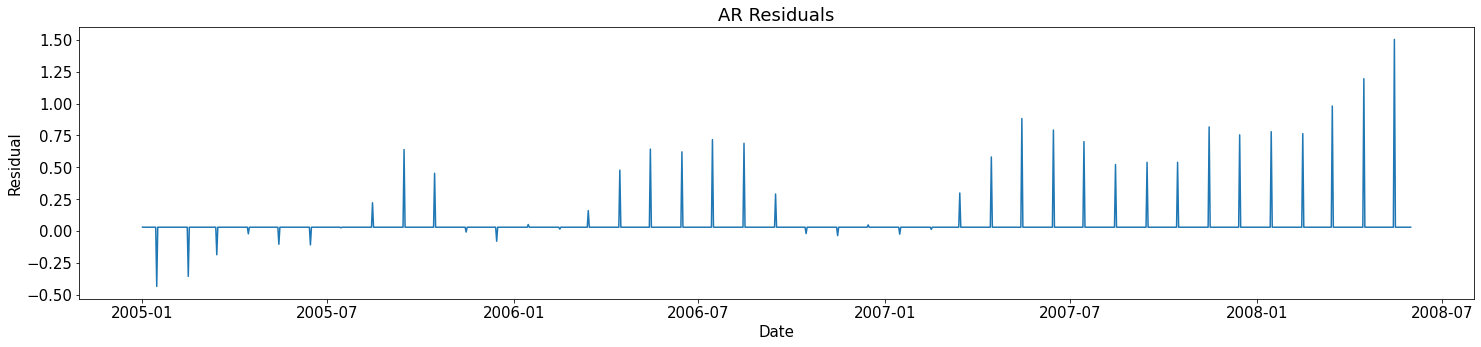

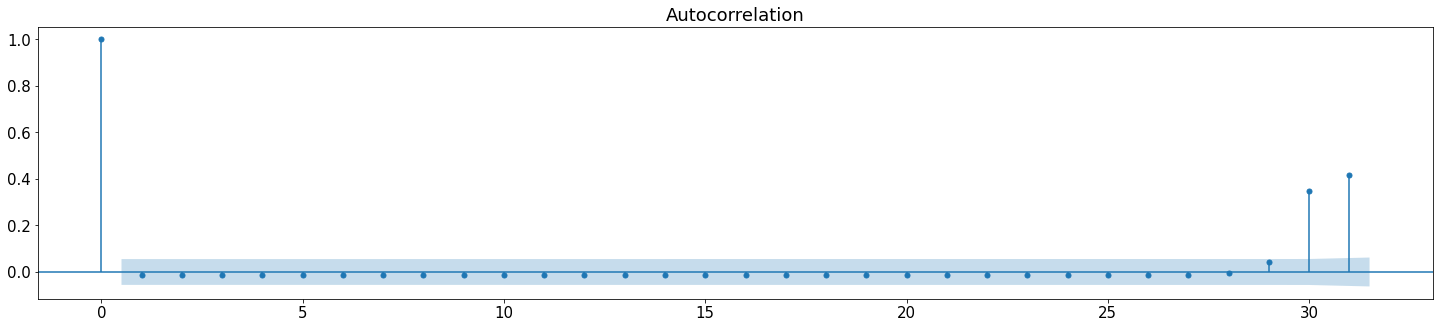

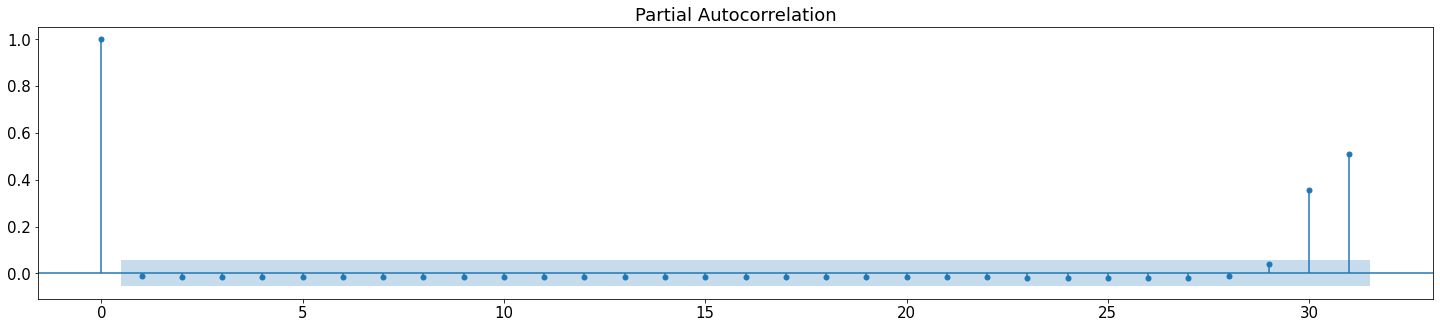

AR Ljung-Box test p-value: 0.996
AR Mean of residuals: 0.043
AR Standard deviation of residuals: 0.100


In [21]:
# Create and fit model
model = AutoReg(train01['Gasoline Prices'], lags=1)
results = model.fit()

# Calculate residuals
AR_residuals = test01['Gasoline Prices'] - results.predict(start=test01.index[0], end=test01.index[-1])

# Plot residuals
plt.plot(AR_residuals)
plt.title('AR Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Plot ACF and PACF of residuals
plot_acf(AR_residuals)
plot_pacf(AR_residuals)
plt.show()

# Perform Ljung-Box test for autocorrelation
AR_lb_test = acorr_ljungbox(AR_residuals, lags=[10])
print('AR Ljung-Box test p-value: %.3f' % AR_lb_test[1][0])

# Calculate mean and standard deviation of residuals
AR_mean_residuals = AR_residuals.mean()
AR_std_residuals = AR_residuals.std()
print('AR Mean of residuals: %.3f' % AR_mean_residuals)
print('AR Standard deviation of residuals: %.3f' % AR_std_residuals)

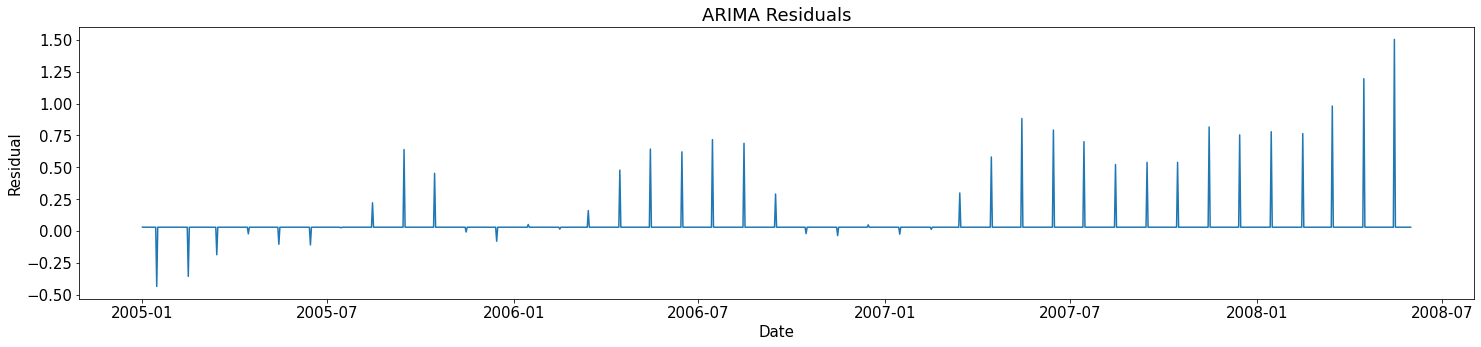

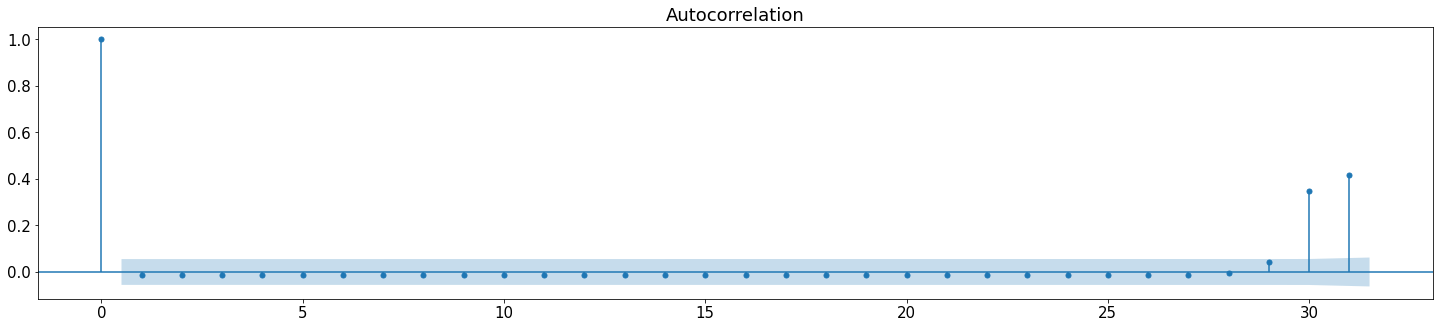

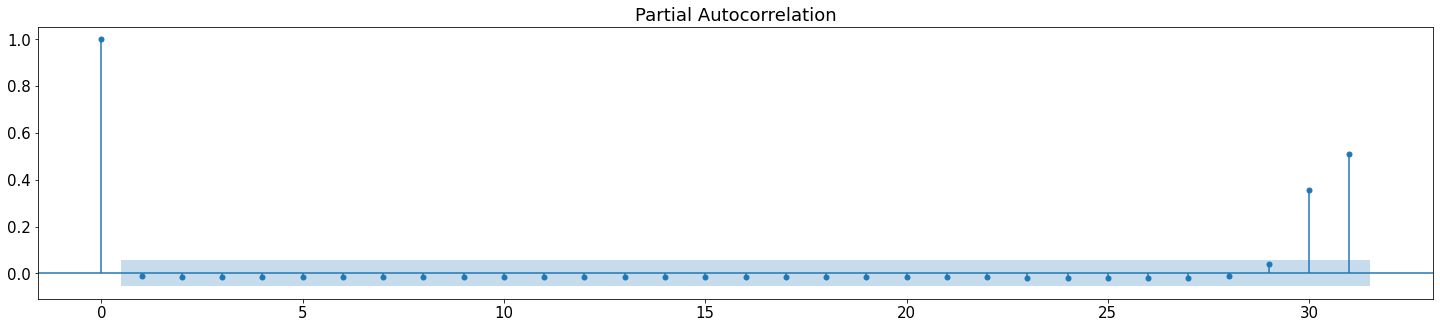

ARIMA Ljung-Box test p-value: 0.996
ARIMA Mean of residuals: 0.043
ARIMA Standard deviation of residuals: 0.100


In [22]:
# Create and fit model
model = ARIMA(train01['Gasoline Prices'], order=(0, 0, 1))
results = model.fit()

# Calculate residuals
ARIMA_residuals = test01['Gasoline Prices'] - results.predict(start=test01.index[0], end=test01.index[-1])

# Plot residuals
plt.plot(ARIMA_residuals)
plt.title('ARIMA Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Plot ACF and PACF of residuals
plot_acf(ARIMA_residuals)
plot_pacf(ARIMA_residuals)
plt.show()

# Perform Ljung-Box test for autocorrelation
ARIMA_lb_test = acorr_ljungbox(ARIMA_residuals, lags=[10])
print('ARIMA Ljung-Box test p-value: %.3f' % ARIMA_lb_test[1][0])

# Calculate mean and standard deviation of residuals
ARIMA_mean_residuals = ARIMA_residuals.mean()
ARIMA_std_residuals = ARIMA_residuals.std()
print('ARIMA Mean of residuals: %.3f' % ARIMA_mean_residuals)
print('ARIMA Standard deviation of residuals: %.3f' % ARIMA_std_residuals)

Exponential Smoothing is better model, which has lower residual mean and standard deviation also P value more than 0.95

<span style="color:blue"> <b> <u>INTERPRETATION :</u> Based on P value, mean and standard deviations, the following inferences can be made:<br><br>
Exponential Smoothing is better model, which has lower residual mean and standard deviation also P value more than 0.95<br><br>

<a id="rmse"></a>
# 9 . Split data for June 2008 forecasting
#### Model with train data till 2005-12-31 and test data till 2008-5-31

In [23]:
# Split data into train and test sets
train_data = june.loc[:'2005-12-31']
test_data = june.loc['2006-01-01':'2008-05-31']

<a id="resi"></a>
# 10 . Forecast for the month of June, 2008. 



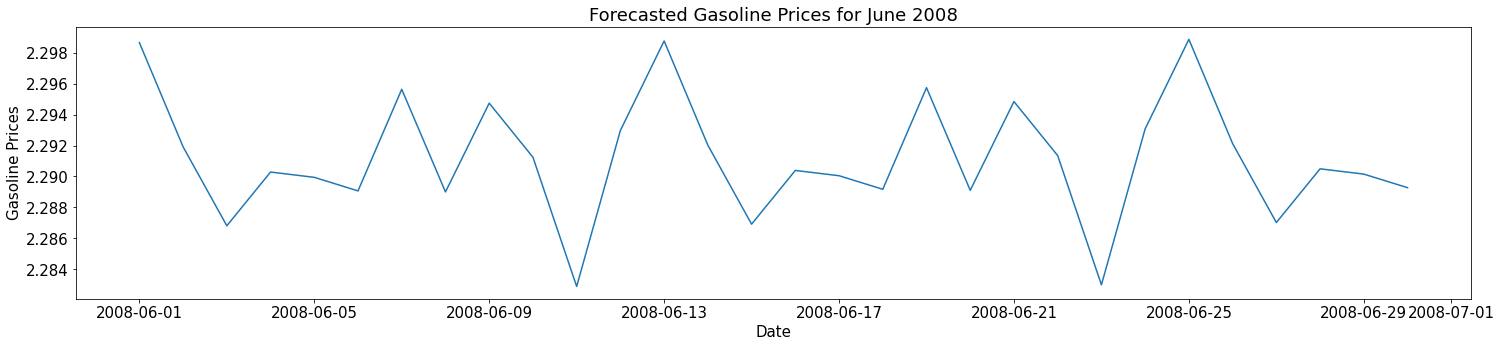

In [24]:
# Create and fit model
model = ExponentialSmoothing(train_data['Gasoline Prices'], trend='add', seasonal='add', seasonal_periods=12)
results = model.fit()

# Make predictions for June 2008
forecast_data = june.loc['2008-06-01':'2008-06-30']
y_forecast = results.predict(start=forecast_data.index[0], end=forecast_data.index[-1])

# Plot forecasted values
plt.plot(forecast_data.index, y_forecast)
plt.title('Forecasted Gasoline Prices for June 2008')
plt.xlabel('Date')
plt.ylabel('Gasoline Prices')
plt.show()

<a id="fin"></a>
# 11 .Final Interpretations

<span style="color:green"> <b> <i> <u> About the Data:</u> <br><br>
    1)The data had no missing values.<br>
    2)On checking Monotonic - The time series is in increasing order.<br>  
<u> Decomposition of time Series:</u> <br>
    1)Additive:The residuals are large compared to the original data, indicating that the additive model may not be a good fit for the time series.<br>
    2)Multiplicative:The residuals are large compared to the original data, indicating that the additive model may not be a good fit for the time series..
Both additive & multiplicative model are not appropriate for the given Gasoline prices time series data.<br>
<br><u> Stationarity:</u> <br>
    The given time series data is non-stationary based on the AD Fuller test and we have changed it to Stationary.<br>
<br><u> Model Building:</u> <br>
    Based on the given performance metrics, Exponential smoothing method appears to be better in performance for the given data.

# Thank You